# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:06<00:00, 9.65kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

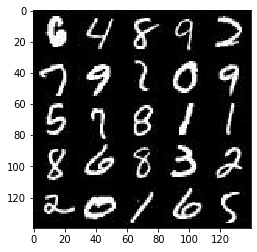

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
# %matplotlib qt5
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

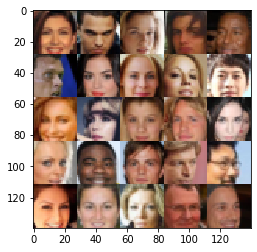

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import os
from glob import glob
from matplotlib import pyplot
# %matplotlib qt5
# img=pyplot.imread('./data/img_align_celeba/000001.jpg')
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/tianran/anaconda3/envs/DLND/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tianran/anaconda3/envs/DLND/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tianran/anaconda3/envs/DLND/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tianran/anaconda3/envs/DLND/lib/python3.7/s

TensorFlow Version: 1.14.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)
    

    return inputs_img, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

# _, tst, _ = model_inputs(10,12,3,128)
# print(type(tst.get_shape().as_list()[1]))


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    print('dicriminator alpha: ', alpha)
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28,28,3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14,14,64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7,7,128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # print(relu3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/tianran/anaconda3/envs/DLND/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3346, in run_code
    return outflag  File "<ipython-input-5-0a8e58cf4972>", line 23, in <module>
    tests.test_model_inputs(model_inputs)  File "/home/tianran/MEGA_Cloud/udacity_workspace/UdacityND/ArtificialIntelligence/DeepLearningND/P4_GenerateFaces/use_tensorflow/problem_unittests.py", line 14, in func_wrapper
    return result  File "/home/tianran/MEGA_Cloud/udacity_workspace/UdacityND/ArtificialIntelligence/DeepLearningND/P4_GenerateFaces/use_tensorflow/problem_unittests.py", line 68, in test_model_inputs
    _check_input(learn_rate, [], 'Learning Rate')  File "/home/tianran/MEGA_Cloud/udac

Instructions for updating:
Use keras.layers.dense instead.
dicriminator alpha:  0.2
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    print('generator alpha: ', alpha)
#     print(z)
#     print(out_channel_dim)
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         print(x1)
        # 3x3x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 1024, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print(x2)
        # 7x7x1024
        x2_ = tf.layers.conv2d_transpose(x2, 512, 5, strides=1, padding='same')
        x2_ = tf.layers.batch_normalization(x2_, training=is_train)
        x2_ = tf.maximum(alpha * x2_, x2_)
        # 7x7x512
        
        x3 = tf.layers.conv2d_transpose(x2_, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         print(x3)
        # 14x14x256 now
        
        # Output layer
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
#         print(logits)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

generator alpha:  0.2
generator alpha:  0.2
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    g_model_test = generator(input_z, out_channel_dim, is_train=False, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real,alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss, g_model_test


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

generator alpha:  0.2
generator alpha:  0.2
dicriminator alpha:  0.2
dicriminator alpha:  0.2
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """
# import numpy as np

# def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode,alpha=0.2):
#     """
#     Show example output for the generator
#     :param sess: TensorFlow session
#     :param n_images: Number of Images to display
#     :param input_z: Input Z Tensor
#     :param out_channel_dim: The number of channels in the output image
#     :param image_mode: The mode to use for images ("RGB" or "L")
#     """
#     cmap = None if image_mode == 'RGB' else 'gray'
#     z_dim = input_z.get_shape().as_list()[-1]
#     example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

#     samples = sess.run(
#         generator(input_z, out_channel_dim, False,alpha=alpha),
#         feed_dict={input_z: example_z})

#     images_grid = helper.images_square_grid(samples, image_mode)
#     images_grid = np.asarray(images_grid, dtype=np.uint8)
#     pyplot.imshow(images_grid, cmap=cmap)
#     pyplot.show()

In [11]:
import numpy as np

def show_generator_output(sess, n_images, z_dim, g_model_test, input_z, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
#     z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run( g_model_test, feed_dict={input_z: example_z}) 
    # generator(input_z, out_channel_dim, False,alpha=alpha)
    images_grid = helper.images_square_grid(samples, image_mode)
    images_grid = np.asarray(images_grid, dtype=np.uint8)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
# tf.reset_default_graph()
def gen_network(data_shape, z_dim, alpha, beta1):
    
    out_channel_dim = data_shape[3]  # (?, h, w, ch)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss, g_model_test = model_loss(input_real, input_z, out_channel_dim,alpha=alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    tf.add_to_collection('inputs', input_real)
    tf.add_to_collection('inputs', input_z)
    tf.add_to_collection('inputs', lr)
    
    tf.add_to_collection('losses', d_loss)
    tf.add_to_collection('losses', g_loss)
    
    tf.add_to_collection('training', d_train_opt)
    tf.add_to_collection('training', g_train_opt)
    
    tf.add_to_collection('g_test', g_model_test)

In [11]:
# def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, 
#           data_image_mode,epoch_show=False,show_steps=100,alpha=0.2):
#     print(data_shape)
#     """
#     Train the GAN
#     :param epoch_count: Number of epochs
#     :param batch_size: Batch Size
#     :param z_dim: Z dimension
#     :param learning_rate: Learning Rate
#     :param beta1: The exponential decay rate for the 1st moment in the optimizer
#     :param get_batches: Function to get batches
#     :param data_shape: Shape of the data
#     :param data_image_mode: The image mode to use for images ("RGB" or "L")
#     """
#     out_channel_dim = data_shape[3]
#     input_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
#     d_loss, g_loss = model_loss(input_real, inputs_z, out_channel_dim,alpha=alpha)
#     d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
#     losses = []
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
#         for epoch_i in range(epoch_count):
#             steps = 0
#             for batch_images in get_batches(batch_size):
#                 batch_images *= 2.0
#                 # Sample random noise for G
#                 batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
#                 # Run optimizers
#                 _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, inputs_z: batch_z, lr: learning_rate})
#                 _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, input_real: batch_images, lr: learning_rate})

#                 if not epoch_show and steps % show_steps == 0:
#                     show_generator_output(sess, 25, inputs_z, out_channel_dim, image_mode=data_image_mode)
#                     print('epoch: {}; steps: {}'.format(epoch_i,steps))
#                 if steps %20 == 0:
#                     train_loss_d = d_loss.eval({inputs_z: batch_z, input_real: batch_images, lr:learning_rate})
#                     train_loss_g = g_loss.eval({inputs_z: batch_z, lr:learning_rate})  
#                     print("Epoch {}/{}...".format(epoch_i+1, epochs),
#                           "Discriminator Loss: {:.4f}...".format(train_loss_d),
#                           "Generator Loss: {:.4f}".format(train_loss_g))
#                     # Save losses to view after training
#                     losses.append([train_loss_d, train_loss_g])
#                 steps += 1
#             if epoch_show:
#                 show_generator_output(sess, 25, inputs_z, out_channel_dim, image_mode=data_image_mode)
#                 print('epoch: ',epoch_i)
#         losses = np.array(losses).T
#         l1, l2 = plt.plot(range(len(losses[0])),losses[0],losses[1])
#         plt.legend([l1, l2], ['d train loss','g train loss'])
#         plt.grid(True)
#         return losses

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def train(sess, inputs, d_g_losses, training_opts, g_model_test, get_batches, batch_size, learning_rate, losses, epoch_count=2, 
          epoch_show=False, show_steps=200):
    input_real, input_z, lr = inputs
    d_loss, g_loss = d_g_losses
    d_train_opt, g_train_opt = training_opts
    g_model_test = g_model_test
    
    tmp_losses = []
    z_dim = input_z.get_shape().as_list()[1]
    out_channel_dim = input_real.get_shape().as_list()[3]
    data_image_mode = 'L' if out_channel_dim == 1 else 'RGB'
    
    for epoch_i in range(epoch_count):
        steps = 0
        for batch_images in get_batches(batch_size):
            batch_images *= 2.0
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

            if not epoch_show and steps % show_steps == 0:
                show_generator_output(sess, 25, z_dim, g_model_test,input_z, image_mode=data_image_mode)
#                 show_generator_output(sess, 25, input_z, out_channel_dim, image_mode=data_image_mode)
                print('epoch: {}; steps: {}'.format(epoch_i,steps))
            if steps %20 == 0:
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})  
                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                # Save losses to view after training
                tmp_losses.append([train_loss_d, train_loss_g])
            steps += 1
        if epoch_show:
            show_generator_output(sess, 25, input_z, out_channel_dim, image_mode=data_image_mode)
            print('epoch: ',epoch_i)
    
    tmp_losses = np.array(tmp_losses).T
    losses = np.hstack((losses, tmp_losses))
    
    l1, l2 = plt.plot(range(len(losses[0])),losses[0],losses[1])
    plt.legend([l1, l2], ['d train loss','g train loss'])
    plt.grid(True)
    
    return losses

In [14]:
def save_losses(losses, n_epoch, filename):
    import pickle
    pickle.dump( (losses, n_epoch), open(filename, "wb" ))
    print('losses and epoch saved!')

def load_losses(filename):
    import pickle
    res = pickle.load(open(filename, 'rb'))
    print('losses and epoch loaded!')
    return res

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator alpha:  0.2
generator alpha:  0.2
dicriminator alpha:  0.2
dicriminator alpha:  0.2


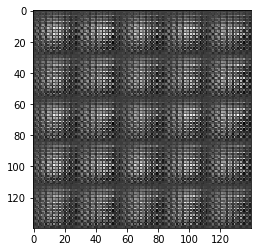

epoch: 0; steps: 0
Epoch 1/1... Discriminator Loss: 10.7832... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 5.0643... Generator Loss: 0.0073
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 0.1621... Generator Loss: 2.7562
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 3.4150
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 8.4080
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 2.6355
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 3.7787
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 2.1840
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6205


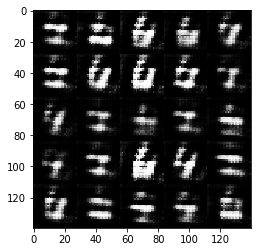

epoch: 0; steps: 200
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.8694
Epoch 1/1... Discriminator Loss: 0.2937... Generator Loss: 2.5971
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 4.6865
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.8176


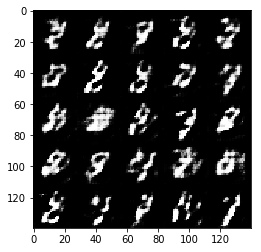

epoch: 0; steps: 400
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 2.9035
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 3.3399
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.0662
Model saved:  ./mnist_ckp/mnist


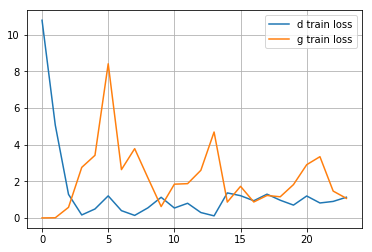

In [16]:
alpha=0.2
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))


file_name_mnist = './mnist_ckp/mnist'
tf.reset_default_graph()
# training
with tf.Session() as sess:
#     saver = tf.train.Saver()
    gen_network(mnist_dataset.shape, z_dim, alpha, beta1)
    inputs = tf.get_collection('inputs')
    d_g_losses = tf.get_collection('losses')
    training_opts = tf.get_collection('training')
    g_model_test = tf.get_collection('g_test')[0]
    
    sess.run(tf.global_variables_initializer())
    losses = np.array([]).reshape(2, -1)
    losses = train(sess, inputs, d_g_losses, training_opts, g_model_test, mnist_dataset.get_batches, batch_size, 
                   learning_rate, losses, epoch_count=epochs)
    saver = tf.train.Saver()
    saver.save(sess, file_name_mnist)
    print("Model saved: ", file_name_mnist)
n_epoch = 1

loss_fname_mnist = './mnist_ckp/mnist_losses.p'
save_losses(losses, n_epoch, loss_fname_mnist)
# with tf.Graph().as_default():
#     train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, 
#           mnist_dataset.shape, mnist_dataset.image_mode,epoch_show=True)    

epoch 1-4: lr=0.0005, batch_size=128
from epoch 5: lr=0.0002, batch_size=64
from epoch 9: lr=0.0005, batch_size=128
from epoch 11: lr=0.0002, batch_size=64

losses and epoch loaded!
this training epoch:  12
INFO:tensorflow:Restoring parameters from ./mnist_ckp/.\mnist


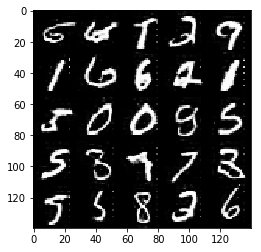

epoch: 0; steps: 0
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.8884... Generator Loss: 0.2317
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 2.2229
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.5994


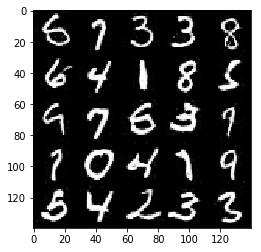

epoch: 0; steps: 200
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 2.0082
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.3135


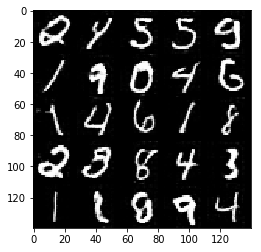

epoch: 0; steps: 400
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 1.7623
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 1.9429
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.0659


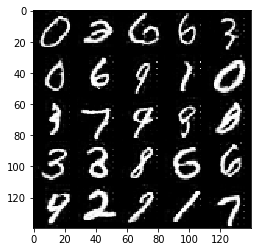

epoch: 0; steps: 600
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.7462
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.3577
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 2.6361
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.9349... Generator Loss: 2.6214
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5012


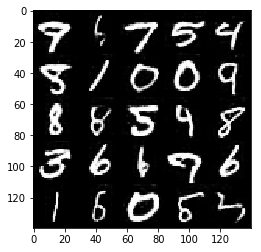

epoch: 0; steps: 800
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 2.7278
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 3.3574
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.1747
Model saved:  ./mnist_ckp/mnist
losses and epoch saved!


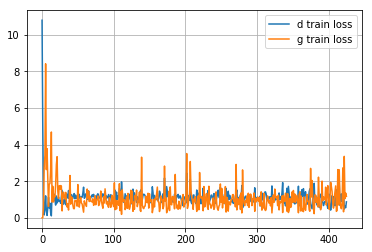

In [17]:
print('epoch 1-4: lr=0.0005, batch_size=128')
print('from epoch 5: lr=0.0002, batch_size=64')
print('from epoch 9: lr=0.0005, batch_size=128')
print('from epoch 11: lr=0.0002, batch_size=64')

print()
file_name_mnist = './mnist_ckp/mnist'
loss_fname_mnist = './mnist_ckp/mnist_losses.p'

losses, n_epoch = load_losses(loss_fname_mnist)
n_epoch += 1
print('this training epoch: ', n_epoch)

batch_size = 64
learning_rate = 0.0002
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

file_name_mnist = './mnist_ckp/mnist'
tf.reset_default_graph()
# training
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(file_name_mnist+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./mnist_ckp/.'))
    inputs = tf.get_collection('inputs')
    d_g_losses = tf.get_collection('losses')
    training_opts = tf.get_collection('training')
    g_model_test = tf.get_collection('g_test')[0]
    losses = train(sess, inputs, d_g_losses, training_opts, g_model_test, mnist_dataset.get_batches, batch_size, 
                   learning_rate, losses, epoch_count=epochs)

    saver.save(sess, file_name_mnist)
    print("Model saved: ", file_name_mnist)
save_losses(losses, n_epoch, loss_fname_mnist)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator alpha:  0.2
generator alpha:  0.2
dicriminator alpha:  0.2
dicriminator alpha:  0.2


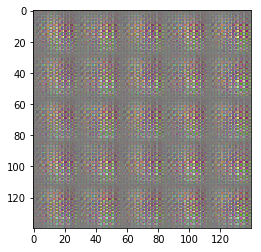

epoch: 0; steps: 0
Epoch 1/1... Discriminator Loss: 10.8429... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 4.3688... Generator Loss: 0.0147
Epoch 1/1... Discriminator Loss: 4.5841... Generator Loss: 0.0218
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.8612... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 2.0478... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.7524... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.3285... Generator Los

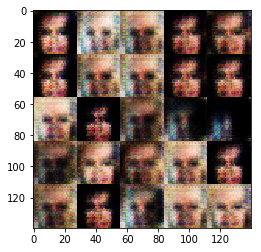

epoch: 0; steps: 400
Epoch 1/1... Discriminator Loss: 1.7547... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.6632
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.8237... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 1.6776... Generator Lo

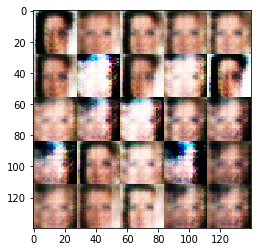

epoch: 0; steps: 800
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.8998... Generator Loss: 1.6294
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 2.2896
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.4296
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.2030... Generator Lo

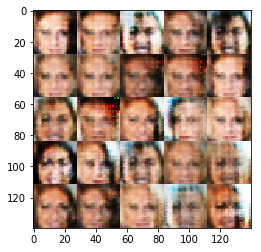

epoch: 0; steps: 1200
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 1.5976
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.7422... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 1.6790... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.8644... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.0369... Generator L

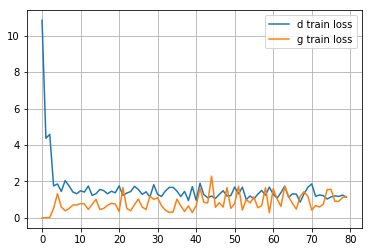

In [20]:
alpha=0.2
batch_size = 128
z_dim = 128
learning_rate = 0.0003
beta1 = 0.2
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

file_name_celeba = './celeba_ckp/celeba'
tf.reset_default_graph()
# training
with tf.Session() as sess:
#     saver = tf.train.Saver()
    gen_network(celeba_dataset.shape, z_dim, alpha, beta1)
    inputs = tf.get_collection('inputs')
    d_g_losses = tf.get_collection('losses')
    training_opts = tf.get_collection('training')
    g_model_test = tf.get_collection('g_test')[0]
    
    sess.run(tf.global_variables_initializer())
    losses = np.array([]).reshape(2, -1)
    losses = train(sess, inputs, d_g_losses, training_opts, g_model_test, celeba_dataset.get_batches, batch_size, 
                   learning_rate, losses, epoch_count=epochs,show_steps=400)
    saver = tf.train.Saver()
    saver.save(sess, file_name_celeba)
    print("Model saved: ", file_name_celeba)
n_epoch = 1

loss_fname_celeba = './celeba_ckp/celeba_losses.p'
save_losses(losses, n_epoch, loss_fname_celeba)

# with tf.Graph().as_default():
#     losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
#           celeba_dataset.shape, celeba_dataset.image_mode,alpha=alpha,show_steps=200)

epoch 1: lr = 0.0003, batch size = 128
epoch 2: lr = 0.0002, batch size = 64
epoch 3: lr = 0.0001, batch size = 64
epoch 4: lr = 0.0001, batch size = 32
epoch 5: lr = 0.00005, batch size = 128
epoch 6: lr = 0.00002, batch size = 128
epoch 7: lr = 0.00005, batch size = 32

losses and epoch loaded!
current training epoch:  7
INFO:tensorflow:Restoring parameters from ./celeba_ckp/.\celeba


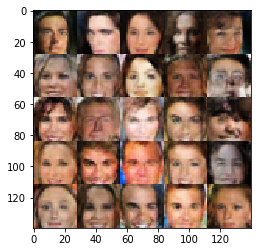

epoch: 0; steps: 0
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 6.7666
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 6.9376
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 6.0137
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 2.4625
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 6.9992
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 5.3438
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 3.0241
Epoch 1/1... Discriminator Loss: 0.2233... Generator Loss: 7.8804
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 6.7929
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 3.6049
Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 3.4843
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 8.3514
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 5.0965
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss

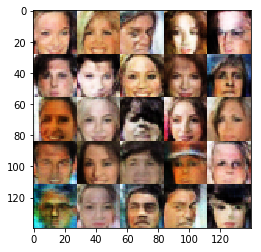

epoch: 0; steps: 1024
Epoch 1/1... Discriminator Loss: 0.1441... Generator Loss: 2.6033
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 6.4706
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 5.9667
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 3.2802
Epoch 1/1... Discriminator Loss: 0.0138... Generator Loss: 5.8031
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 4.3572
Epoch 1/1... Discriminator Loss: 0.0866... Generator Loss: 3.5788
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 9.3474
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 2.5990
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 7.0702
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 2.8736
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 5.8160
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 7.3119
Epoch 1/1... Discriminator Loss: 0.0375... Generator L

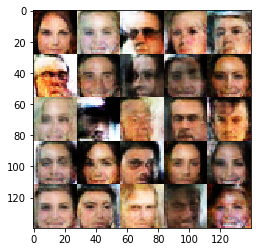

epoch: 0; steps: 2048
Epoch 1/1... Discriminator Loss: 1.8636... Generator Loss: 0.3152
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 6.6060
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 5.9466
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 3.9563
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 5.9449
Epoch 1/1... Discriminator Loss: 0.0750... Generator Loss: 3.4566
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 6.0499
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 5.5372
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 2.2774
Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 3.6862
Epoch 1/1... Discriminator Loss: 0.3011... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 4.9890
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 7.8253
Epoch 1/1... Discriminator Loss: 0.1837... Generator L

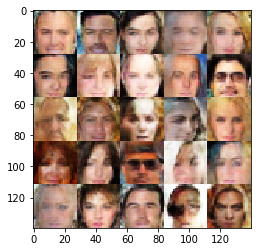

epoch: 0; steps: 3072
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 4.1501
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 4.5830
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 4.6214
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 3.1021
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 4.3494
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 5.8672
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 7.0761
Epoch 1/1... Discriminator Loss: 0.2726... Generator Loss: 2.7311
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 3.0516
Epoch 1/1... Discriminator Loss: 2.4141... Generator Loss: 0.2282
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 6.2961
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 6.2718
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 5.9991
Epoch 1/1... Discriminator Loss: 0.0400... Generator L

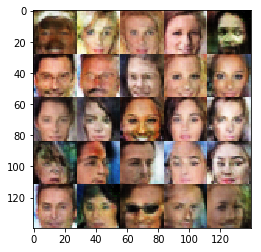

epoch: 0; steps: 4096
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 7.9347
Epoch 1/1... Discriminator Loss: 0.2323... Generator Loss: 2.9148
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.1635... Generator Loss: 9.1384
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 2.5561
Epoch 1/1... Discriminator Loss: 0.0350... Generator Loss: 4.3461
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 4.7698
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 1.7295
Epoch 1/1... Discriminator Loss: 0.2160... Generator Loss: 5.5052
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 1.9081... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 2.5173
Epoch 1/1... Discriminator Loss: 0.1642... Generator Loss: 2.6969
Epoch 1/1... Discriminator Loss: 0.0801... Generator L

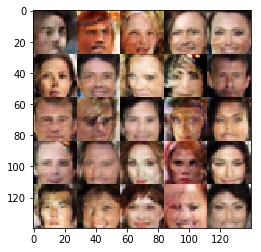

epoch: 0; steps: 5120
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 0.1143... Generator Loss: 3.1983
Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 2.0949
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 3.4144
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 4.9717
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 5.2401
Epoch 1/1... Discriminator Loss: 1.7442... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 5.0025
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 6.0793
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 7.4295
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 2.4713
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 1.5464
Epoch 1/1... Discriminator Loss: 0.8226... Generator L

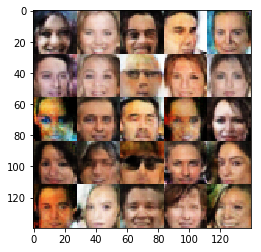

epoch: 0; steps: 6144
Epoch 1/1... Discriminator Loss: 0.2339... Generator Loss: 4.4647
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 5.4698
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 5.6452
Epoch 1/1... Discriminator Loss: 0.0257... Generator Loss: 4.9005
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 5.4107
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 5.7204
Epoch 1/1... Discriminator Loss: 0.3119... Generator Loss: 2.2326
Model saved:  ./celeba_ckp/celeba
losses and epoch saved!


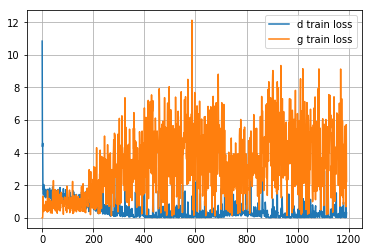

In [26]:
print('epoch 1: lr = 0.0003, batch size = 128')
print('epoch 2: lr = 0.0002, batch size = 64')
print('epoch 3: lr = 0.0001, batch size = 64')
print('epoch 4: lr = 0.0001, batch size = 32')
print('epoch 5: lr = 0.00005, batch size = 128')
print('epoch 6: lr = 0.00002, batch size = 128')
print('epoch 7: lr = 0.00005, batch size = 32')

print()
file_name_celeba = './celeba_ckp/celeba'
loss_fname_celeba = './celeba_ckp/celeba_losses.p'

losses, n_epoch = load_losses(loss_fname_celeba)
n_epoch += 1
print('current training epoch: ', n_epoch)

batch_size = 32
learning_rate = 0.00005
epochs = 1

show_steps=1024

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

file_name_celeba = './celeba_ckp/celeba'
tf.reset_default_graph()
# training
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(file_name_celeba+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./celeba_ckp/.'))
    inputs = tf.get_collection('inputs')
    d_g_losses = tf.get_collection('losses')
    training_opts = tf.get_collection('training')
    g_model_test = tf.get_collection('g_test')[0]
    losses = train(sess, inputs, d_g_losses, training_opts, g_model_test, celeba_dataset.get_batches, batch_size, 
                   learning_rate, losses, epoch_count=epochs, show_steps=show_steps)

    saver.save(sess, file_name_celeba)
    print("Model saved: ", file_name_celeba)
save_losses(losses, n_epoch, loss_fname_celeba)